In [1]:
# ConvolutionalNeuralNetwork_Xrays_Pneumonia
# Dataset : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
# Referenced from : https://www.kaggle.com/pranjalverma08/pneumonia-detection-from-scratch

import numpy as np # data manipulation
import pandas as pd # used to load and manipulate data
import matplotlib.pyplot as plt # used for plotting data
import plotly # another data plotting library
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import cv2 # OpenCV for Python
import random # randomization
import os
import glob # used to group image data pulled from a directory
from tqdm.notebook import tqdm
import albumentations as A
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout , BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau # callbacks are called between each epoch

C:\Users\Arjun\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning:

Blowfish has been deprecated



In [2]:
# Creating the train, test and validation datasets


train_data = glob.glob('C:\\Users\\Arjun\\Downloads\\chest_xray\\train\\**\\*.jpeg')
test_data = glob.glob('C:\\Users\\Arjun\\Downloads\\chest_xray\\test\\**\\*.jpeg')
val_data = glob.glob('C:\\Users\\Arjun\\Downloads\\chest_xray\\val\\**\\*.jpeg')

# Displaying the number of images in the train, test and validation folders

print(f"Training data size : {len(train_data)} images")
print(f"Testing data size : {len(test_data)} images")
print(f"Validation data size : {len(val_data)} images")

Training data size : 5216 images
Testing data size : 624 images
Validation data size : 16 images


In [3]:
# Creating variables to store the pneumonia xray scans and normal xray scans


DIR = "C:\\Users\\Arjun\\Downloads\\chest_xray"
sets = ["train", "test", "val"]
all_pneumonia = []
all_normal = []

# Iterating through each folder (train test val) to retrieve each set of images for the section
for cat in sets:
    path = os.path.join(DIR, cat)
    norm = glob.glob(os.path.join(path, "NORMAL\\*.jpeg"))
    pneu = glob.glob(os.path.join(path, "PNEUMONIA\\*.jpeg"))
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)

print(f"Total Pneumonia Images: {len(all_pneumonia)}")
print(f"Total Normal Images: {len(all_normal)}")


Total Pneumonia Images: 4273
Total Normal Images: 1583


In [4]:
# Randomizing all xray images from both normal and pneumonia arrays

random.shuffle(all_normal)
random.shuffle(all_pneumonia)

images = all_normal[:50] + all_pneumonia[:50]

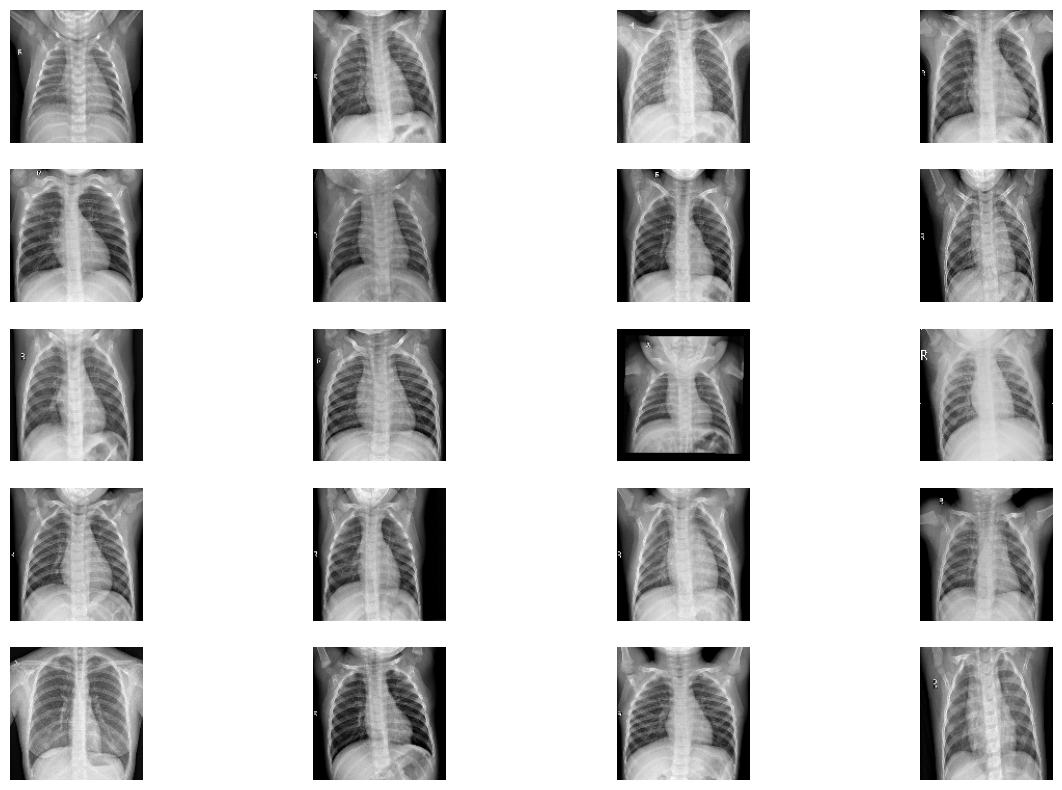

In [5]:
# Plotting the data to ensure images have been processed correctly

fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 5

for i in range(1, columns*rows + 1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (128, 128))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

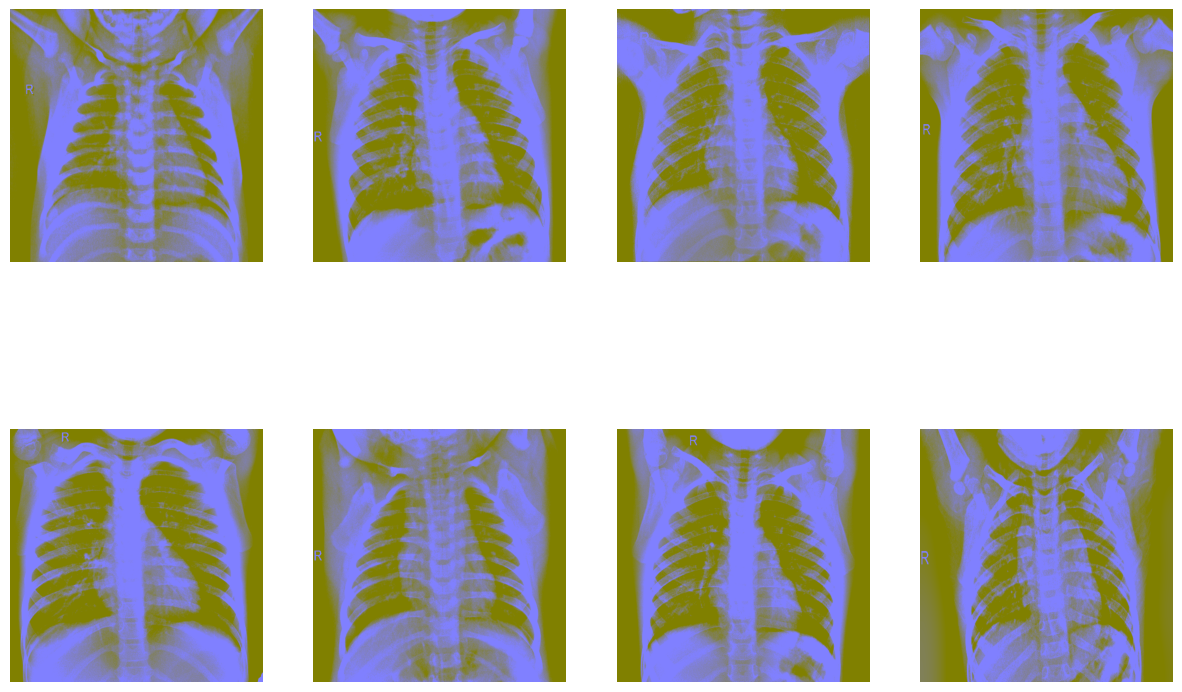

In [6]:
# Preprocessing the image, to minimize noise
# Applying greyscale then a gausssian blur using opencv
# Upscaing images into a 512X512 pixel size

fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 2

for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

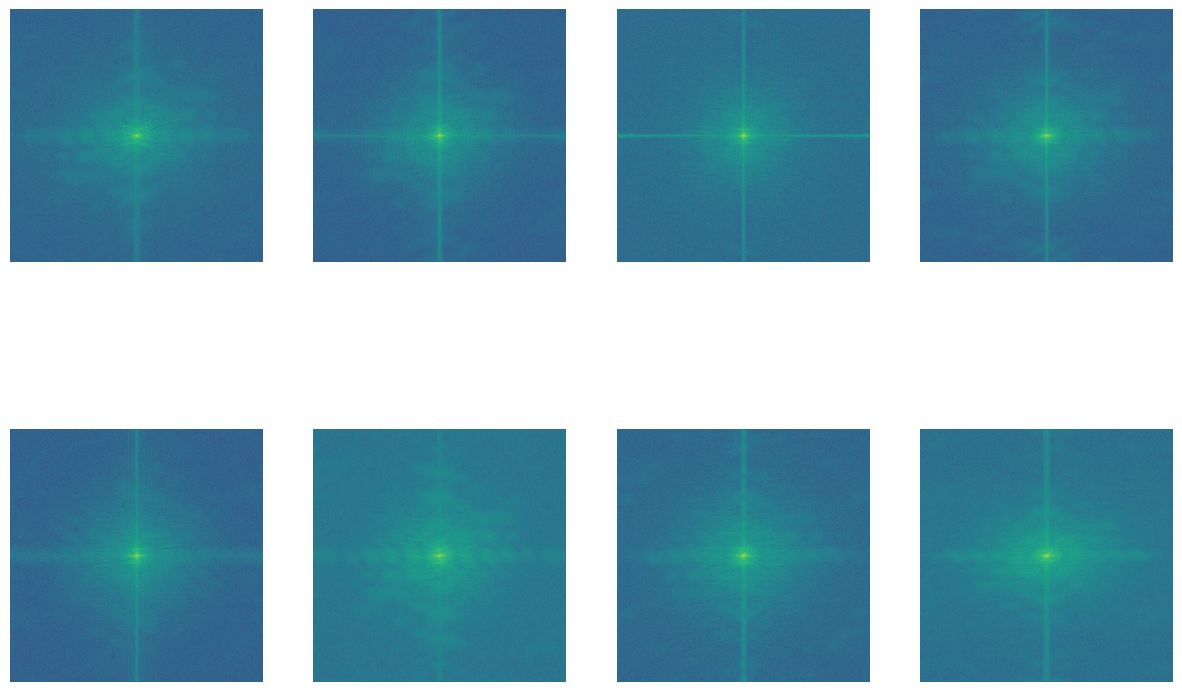

In [7]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 2

for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    fig.add_subplot(rows, columns, i)
    plt.imshow(magnitude_spectrum)
    plt.axis(False)

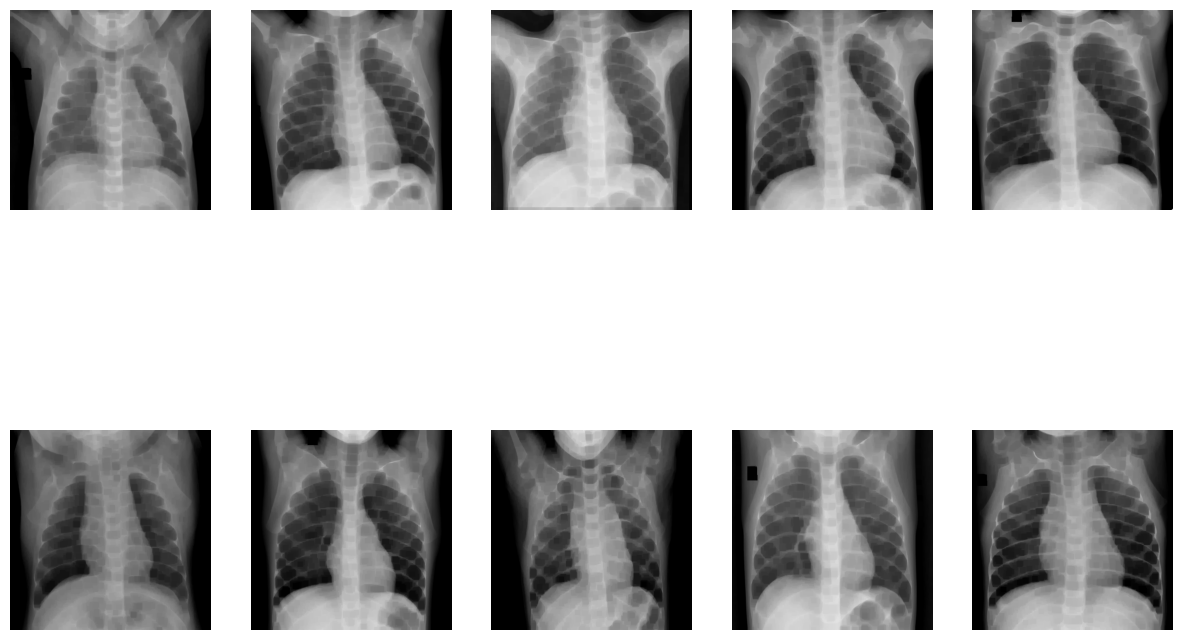

In [8]:
# Implementing image erosion, utilizing opencv

fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 2

for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.erode(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_erosion)
    plt.axis(False)

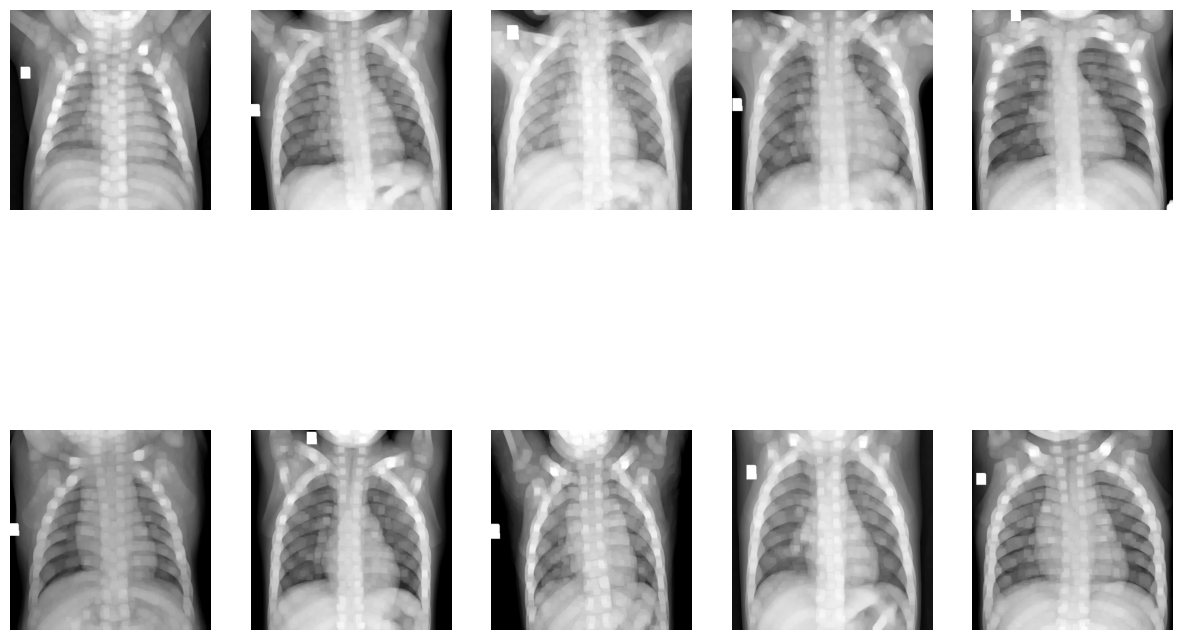

In [9]:
# Implementing the dilation of the images

fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 2

for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.dilate(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_erosion)
    plt.axis(False)

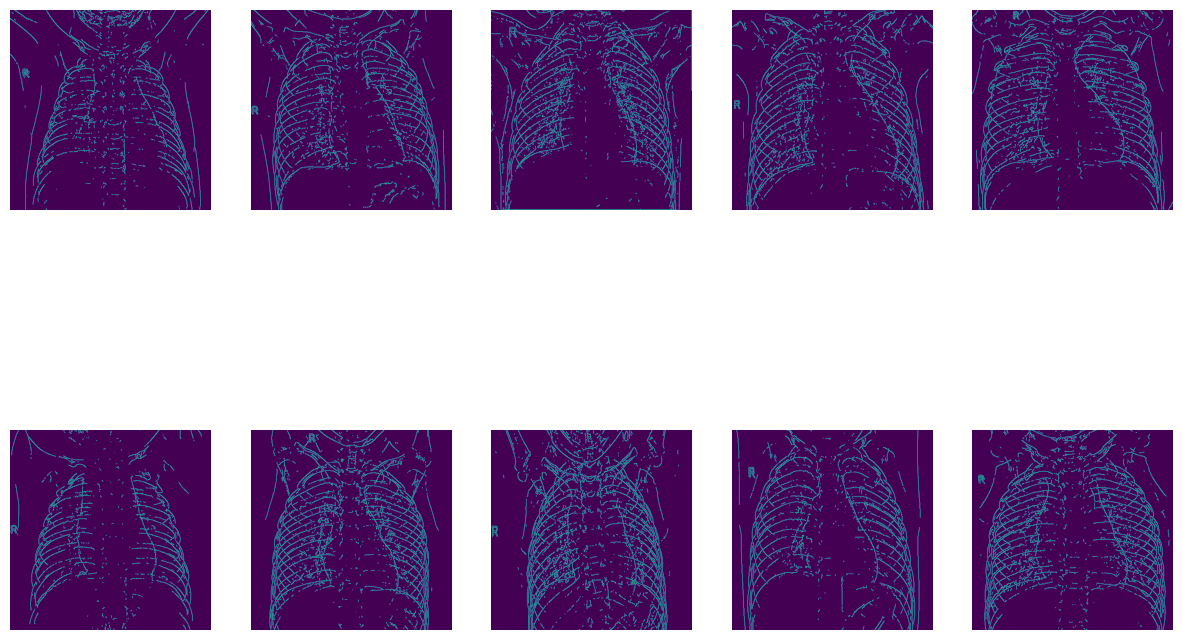

In [10]:
# Utilizing OpenVC's canny edge detection

fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 2

for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(img, 80, 100)
    fig.add_subplot(rows, columns, i)
    plt.imshow(edges)
    plt.axis(False)

In [11]:
# Dividing the data to create train and validation sets using Keras Image DataGenerator

train_gen = ImageDataGenerator(
    rescale=1/255.,
    horizontal_flip=True,
    vertical_flip=False,
    rotation_range=0.3,
    zoom_range=0.4
)

val_gen = ImageDataGenerator(
    rescale=1/255.,
)

In [12]:
# Declaring train and validation variables, that hold all the pneumonia xray scans from the train and test folders

Train = train_gen.flow_from_directory(
    "C:\\Users\\Arjun\\Downloads\\chest_xray\\train",batch_size=16,
    target_size=(224, 224),#class_mode="binary" 
)

val = train_gen.flow_from_directory(
    "C:\\Users\\Arjun\\Downloads\\chest_xray\\test",batch_size=8,
    target_size=(224, 224),#class_mode="binary" 
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [13]:
# Building the Convolutional Neural Network

model = Sequential()

# 1st convolutional layer
model.add(Conv2D(32,(3,3),strides=(1, 1),activation='relu',padding='same', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

# 2nd convolutional layer
model.add(Conv2D(64,(3,3),strides=(1, 1) ,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# 3rd convolutional layer
model.add(Conv2D(128,(3,3),strides=(1, 1),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# 4th convolutional layer
model.add(Conv2D(256,(3,3),strides=(1, 1),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [14]:
# Compiling the model utilizing Categorical Corssentropy (CC) for loss

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Training the model

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

history = model.fit_generator(Train,epochs=20,validation_data=val,steps_per_epoch=50,callbacks=[early_stopping_cb])

C:\Users\Arjun\AppData\Local\Temp\ipykernel_10884\3852376254.py:5: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/20
50/50 [==============================] - 28s 535ms/step - loss: 0.5588 - accuracy: 0.7450 - val_loss: 0.6087 - val_accuracy: 0.6266
Epoch 2/20
50/50 [==============================] - 26s 512ms/step - loss: 0.4580 - accuracy: 0.7825 - val_loss: 0.7042 - val_accuracy: 0.6506
Epoch 3/20
50/50 [==============================] - 26s 517ms/step - loss: 0.4946 - accuracy: 0.7763 - val_loss: 0.6598 - val_accuracy: 0.6699
Epoch 4/20
50/50 [==============================] - 26s 519ms/step - loss: 0.4689 - accuracy: 0.7850 - val_loss: 0.6002 - val_accuracy: 0.6426
Epoch 5/20
50/50 [==============================] - 27s 547ms/step - loss: 0.3653 - accuracy: 0.8438 - val_loss: 0.5000 - val_accuracy: 0.7788
Epoch 6/20
50/50 [==============================] - 26s 522ms/step - loss: 0.3187 - accuracy: 0.8637 - val_loss: 0.5162 - val_accuracy: 0.7564
Epoch 7/20
50/50 [==============================] - 26s 520ms/step - loss: 0.3181 - accuracy: 0.8525 - val_loss: 0.4115 - val_accuracy: 0.8141

In [16]:
# Displaying the training accuracy of the CNN

print('This model has a training accuracy of: {}%'.format(np.round(history.history['accuracy'][-1]*100, 2)))

This model has a training accuracy of: 90.5%


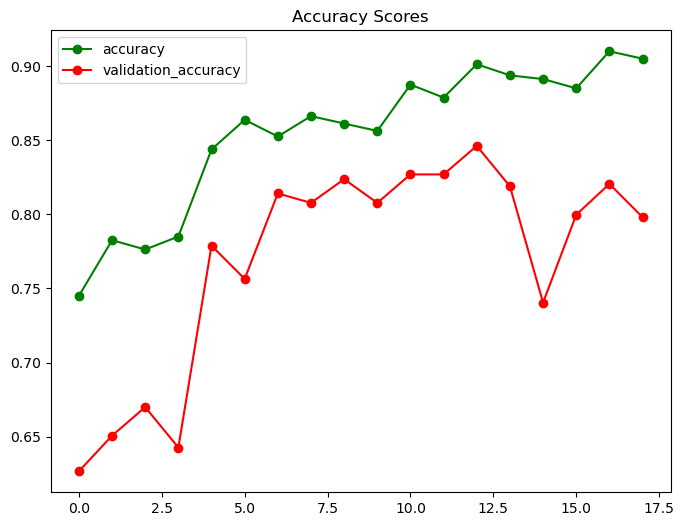

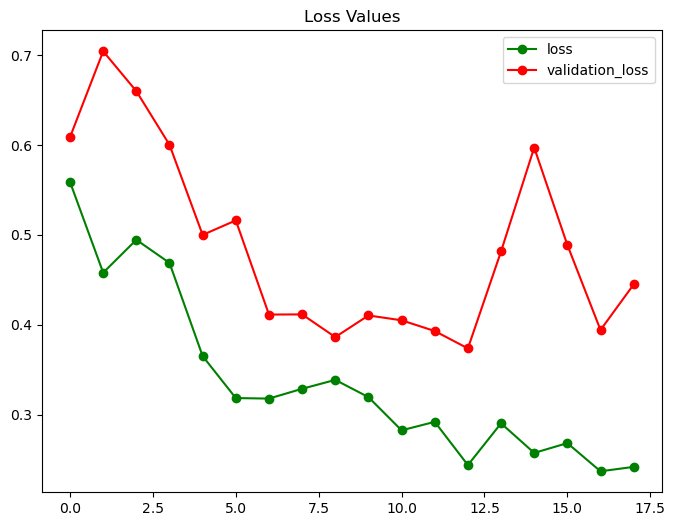

In [17]:
# Plotting the accuracy and loss data to visualize the performance of our model (loss refers to a prediction error in this case)

plt.figure(figsize=(8,6))
plt.title('Accuracy Scores')
plt.plot(history.history['accuracy'],'go-')
plt.plot(history.history['val_accuracy'],'ro-')
plt.legend(['accuracy', 'validation_accuracy'])
plt.show()


plt.figure(figsize=(8,6))
plt.title('Loss Values')
plt.plot(history.history['loss'],'go-')
plt.plot(history.history['val_loss'],'ro-')
plt.legend(['loss', 'validation_loss'])
plt.show()